In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [3]:
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

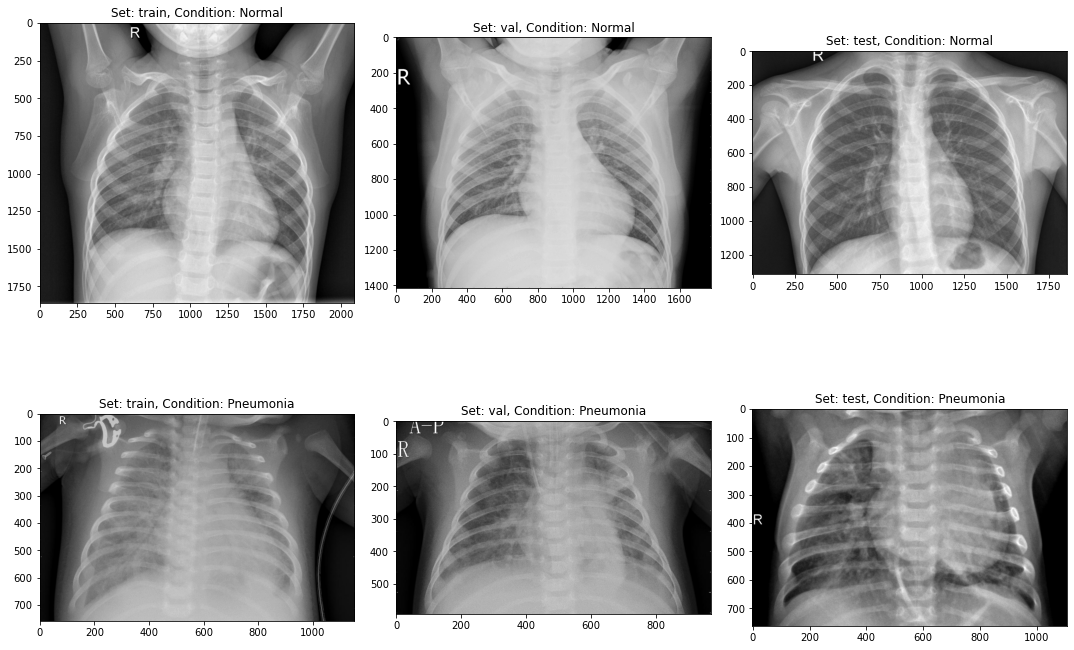

In [4]:
path = 'D:/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [5]:
def process_data(img_dims, batch_size):
    
    # Data generation objects
    train_datagen = image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
    
    test_val_datagen = ImageDataGenerator(
                                    rescale=1./255
                                )
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
                    directory= path + 'train', 
                    target_size=(img_dims, img_dims), 
                    batch_size=batch_size, 
                    class_mode='binary', 
                    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
                    directory= path + 'test', 
                    target_size=(img_dims, img_dims), 
                    batch_size=batch_size, 
                    class_mode='binary', 
                    shuffle=True)
    
    val_gen = test_val_datagen.flow_from_directory(
                    directory= path + 'val', 
                    target_size=(img_dims, img_dims), 
                    batch_size=batch_size, 
                    class_mode='binary', 
                    shuffle=True)
    
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path + 'test' + cond)):
            img = plt.imread(path + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [6]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
## CNN Architecture

inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [9]:
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])


Epoch 1/10
163/163 [==============================] - 151s 923ms/step - loss: 0.3287 - accuracy: 0.8524 - val_loss: 0.6731 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 89s 546ms/step - loss: 0.2374 - accuracy: 0.9101 - val_loss: 0.8313 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 84s 515ms/step - loss: 0.1905 - accuracy: 0.9296 - val_loss: 2.2629 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 83s 506ms/step - loss: 0.1750 - accuracy: 0.9369 - val_loss: 2.1333 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9425
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 82s 502ms/step - loss: 0.1593 - accuracy: 0.9425 - val_loss: 0.4532 - val_accuracy: 0.7878 - lr: 0.0010
Epoch 6/10
163/163 [============================

In [10]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 75, 75, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 75, 75, 32)       1344  

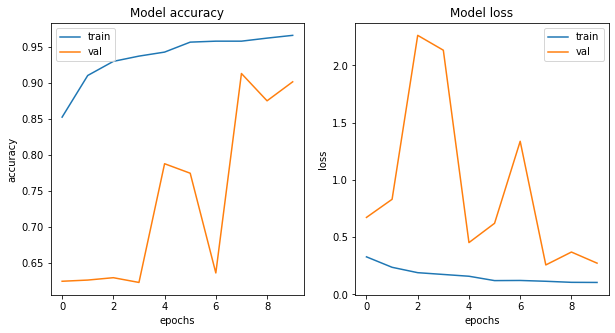

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    
    ax[i].set_title('Model {}'.format(met))
    
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    
    ax[i].legend(['train', 'val'])

In [12]:
!pip install sklearn

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix


preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))


20/20 [==============================] - 2s 84ms/step
CONFUSION MATRIX ------------------
[[184  50]
 [  8 382]]

TEST METRICS ----------------------
Accuracy: 90.7051282051282%
Precision: 88.42592592592592%
Recall: 97.94871794871794%
F1-score: 92.94403892944038

TRAIN METRIC ----------------------
Train acc: 96.57


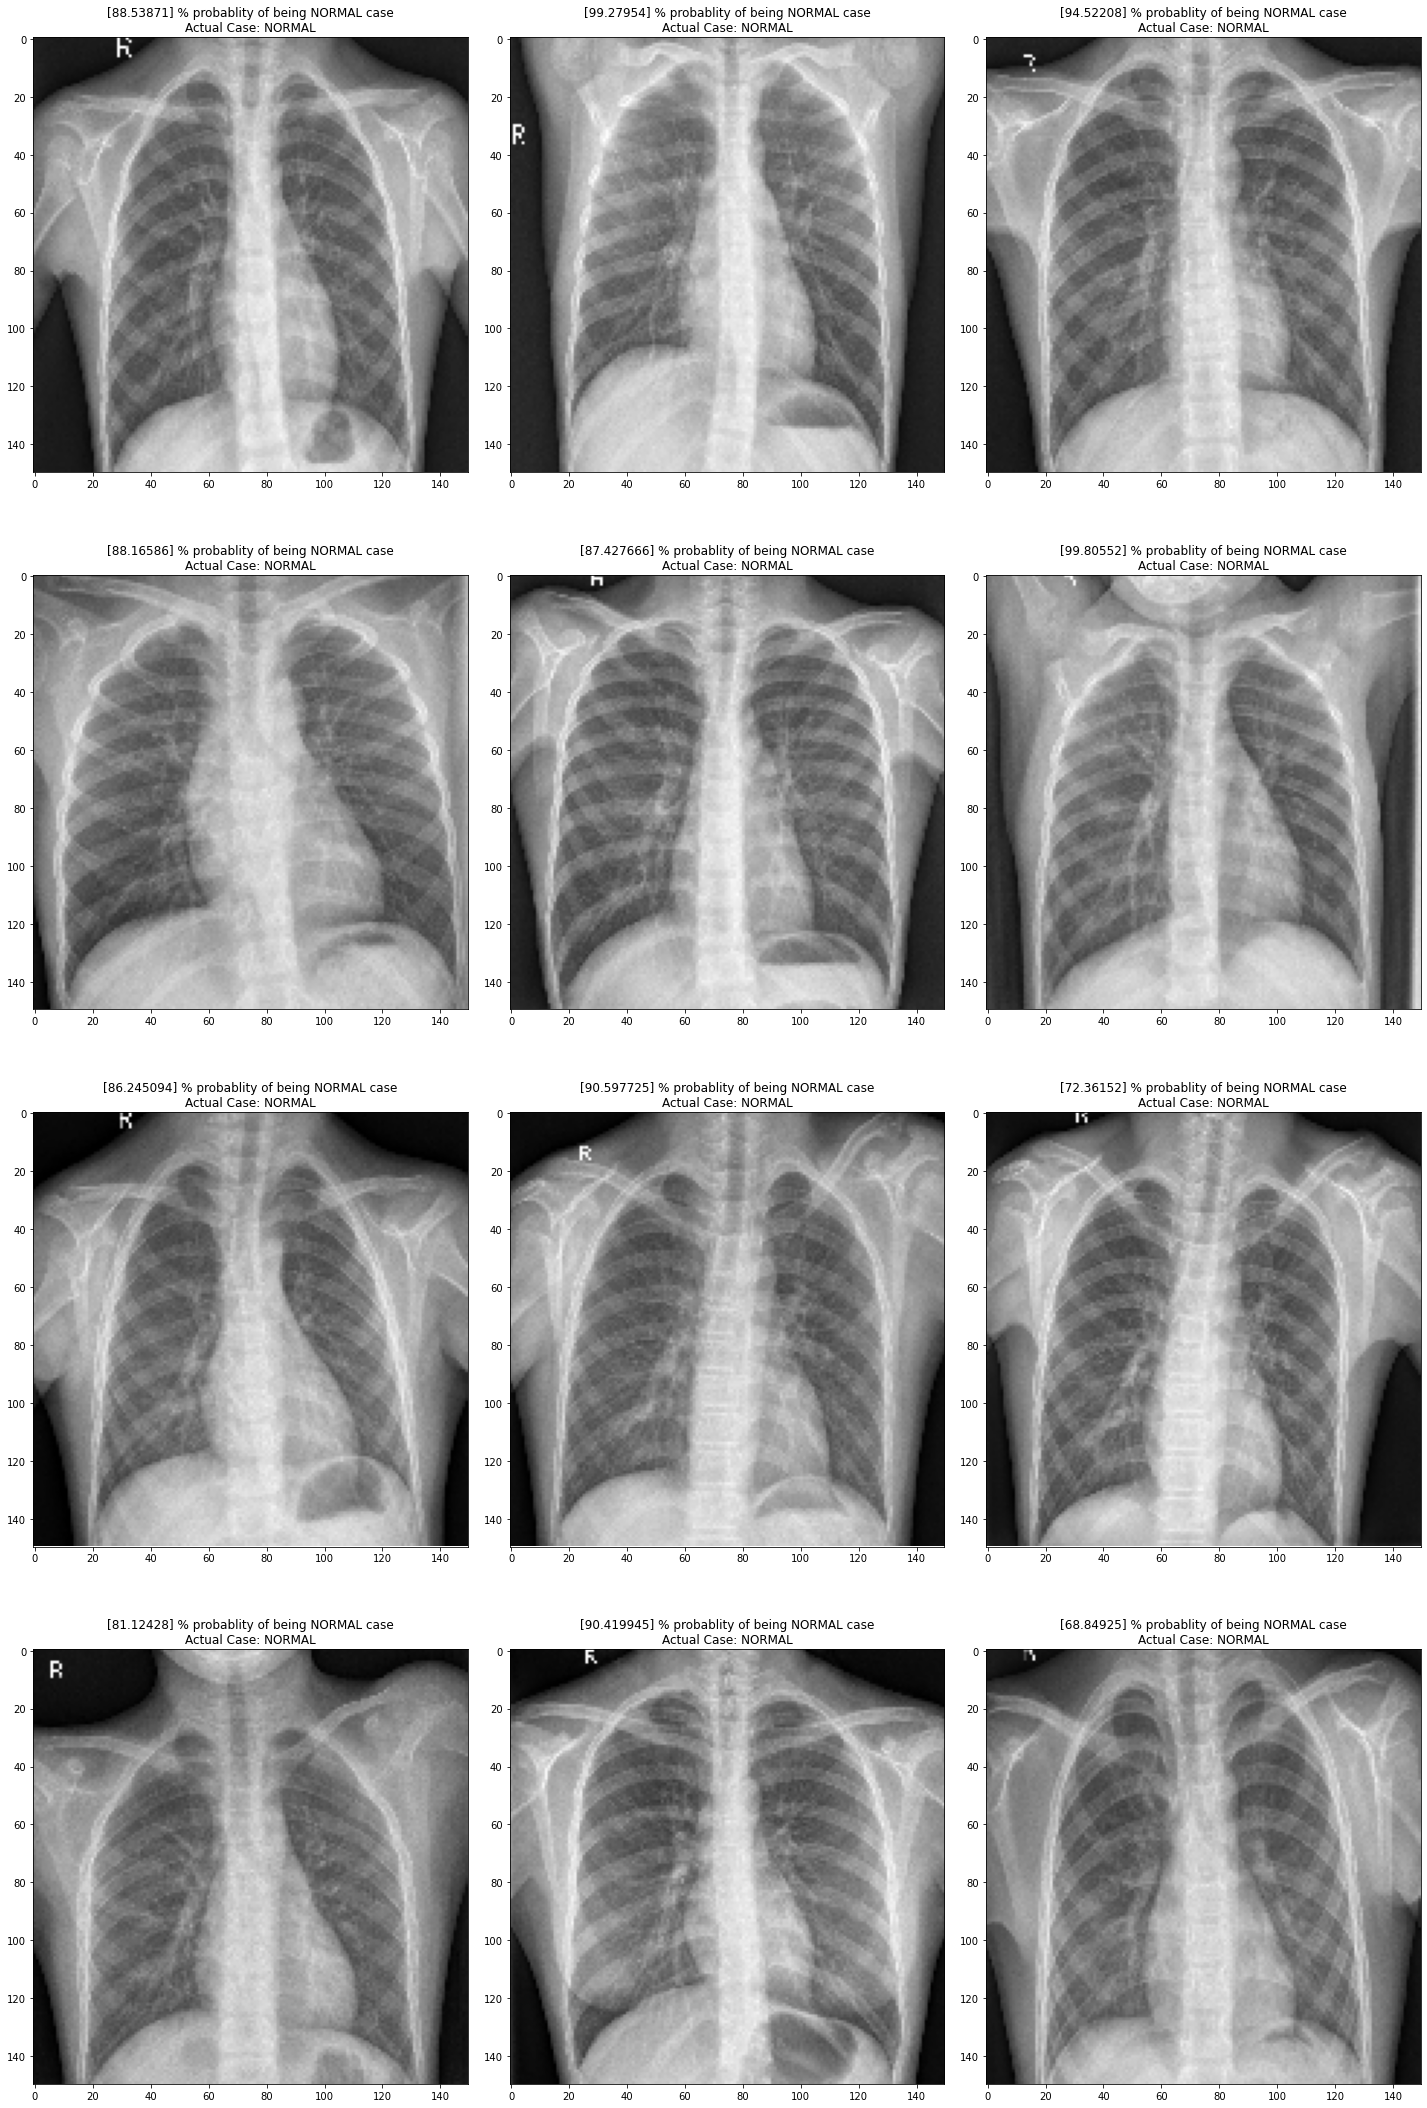

In [14]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    ax[i].imshow(test_data[i], cmap='gray')
    
    if test_labels[i] == 0:
        ax[i].set_title('{} % probablity of being NORMAL case'.format((1 - preds[i])*100) + '\n' + 'Actual Case: NORMAL')
    else:
        ax[i].set_title('{} % probablity of being PNEUMONIA case'.format(preds[i]*100) + '\n' + 'Actual Case: PNEUMONIA')

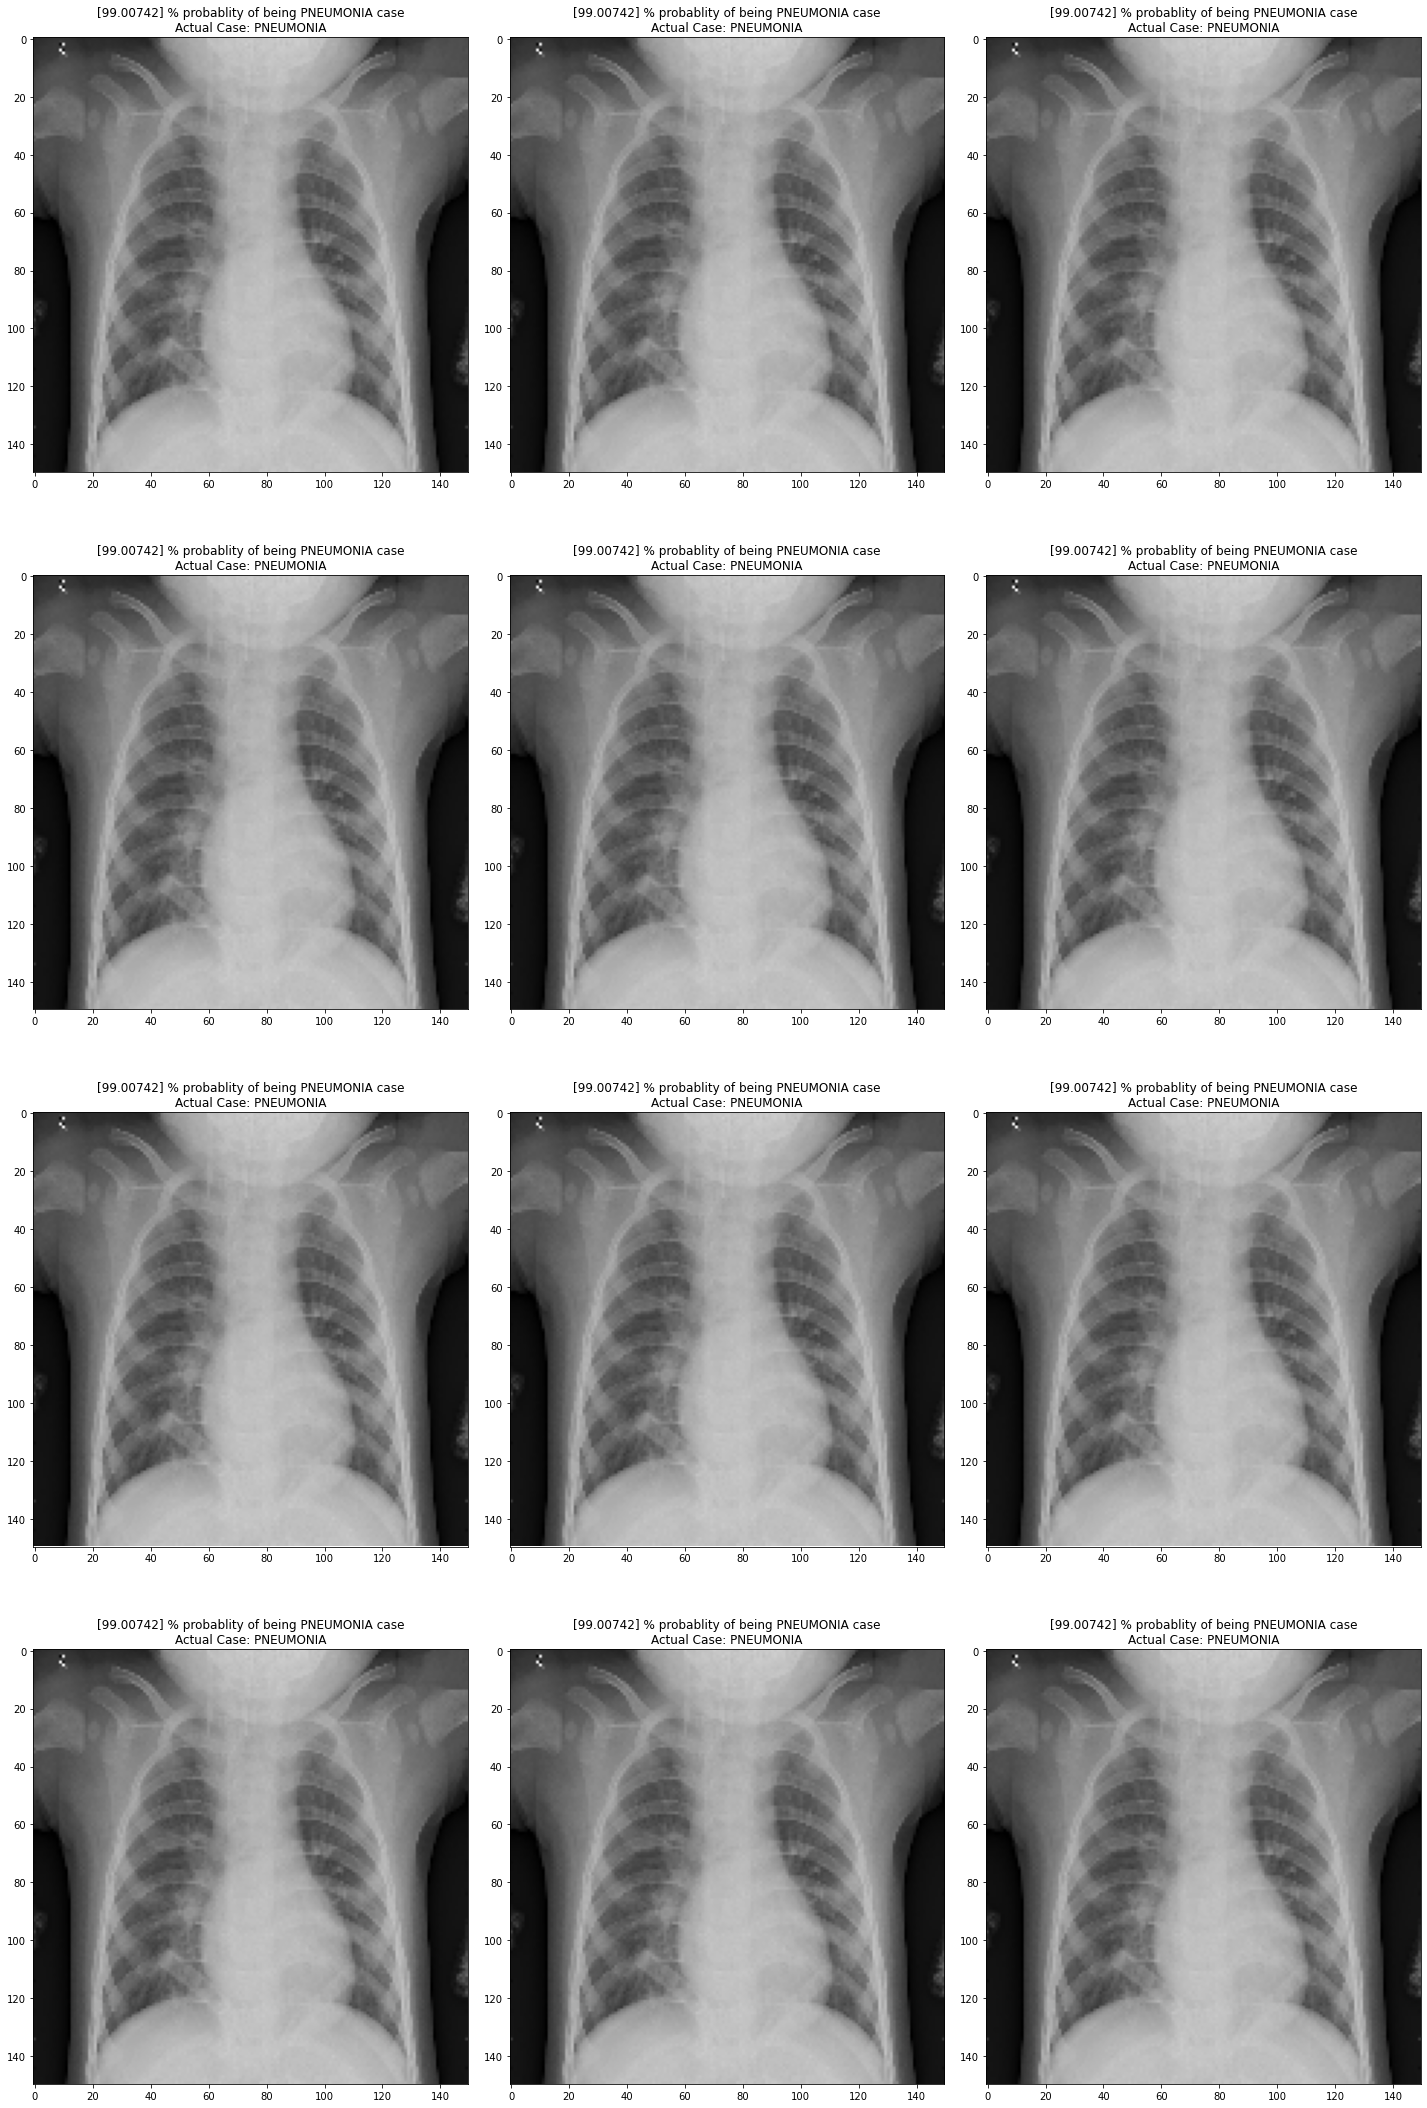

In [15]:
fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    for j in range(234, 246):
        ax[i].imshow(test_data[j])
    
        if test_labels[j] == 0:
            ax[i].set_title('{} % probablity of being NORMAL case'.format((1 - preds[j])*100) + '\n' + 'Actual Case: NORMAL')
        else:
            ax[i].set_title('{} % probablity of being PNEUMONIA case'.format(preds[j]*100) + '\n' + 'Actual Case: PNEUMONIA')

In [26]:
from keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

model = load_model("final_model.h5")
img_dims = 150
path = 'D:/chest_xray/'

test_val_datagen = ImageDataGenerator(
            rescale=1. / 255
        )
val_gen = test_val_datagen.flow_from_directory(
        directory=path  + 'val',
        target_size=(img_dims, img_dims),
        batch_size=2,
        class_mode='binary',
        shuffle=False)

"""model.summary()
print('##################')
print(model.layers)
print('num of layers: ' + str(len(model.layers)) + ' layer')"""


# path = './chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'
# img = plt.imread(path)
# img = cv2.resize(img, (150, 150))
# img = np.dstack([img, img, img])
# img = img.astype('float32') / 255
# pre = model.predict(img)
# print(pre)

# model.predict('\chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg')

preds = model.predict(val_gen);
for i in preds :
        if(i <= .5):
                print("Normal")
        else :
                print("Not Normal")

Found 16 images belonging to 2 classes.
8/8 [==============================] - 1s 49ms/step
Not Normal
Not Normal
Not Normal
Not Normal
Normal
Not Normal
Normal
Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
Not Normal
